In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
plt.style.use('ggplot')

%matplotlib inline

In [2]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [3]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [4]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


In [5]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


In [6]:
input_len = 16 # try wider window power of 2
horizon = 7 # prediction window

# Trying out different input_len and horizon
input_len = 64
horizon = 7

In [7]:
features = features[['pressure','dpdt','seismic']]

In [8]:
features

,pressure,dpdt,seismic
0,8.599065e+06,0.017439,1.0
1,8.601838e+06,0.018007,1.0
2,8.604612e+06,0.018575,2.0
3,8.607385e+06,0.019143,2.0
4,8.610158e+06,0.019711,2.0
...,...,...,...
1106,8.652984e+06,-0.029754,4886.0
1107,8.649775e+06,-0.030196,4886.0
1108,8.646565e+06,-0.030638,4889.0
1109,8.643355e+06,-0.031079,4890.0


Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

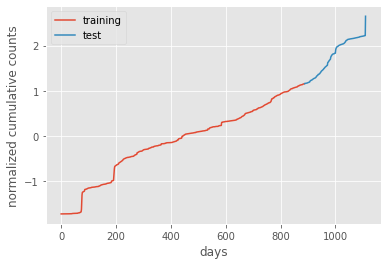

In [9]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    train_test_split=0.8, normalize_data=True # try train_test_split=0.75
    # train_test_split=0.75, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

### Model Architecture

In [10]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [11]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

# Choose your loss function!/
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

In [12]:

from tqdm.notebook import tqdm

In [13]:
torch.manual_seed(0) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

  0%|          | 0/64 [00:00<?, ?it/s]

In [14]:
# print Huber Loss
test_loss_vals

[0.02121907230466604,
 0.011216092389076948,
 0.0036151260952465235,
 0.0019868467934429646,
 0.0012910275196190923,
 0.0008611781406216324,
 0.0008153581293299794,
 0.0006570254394318908,
 0.0006174041453050449,
 0.0006498607312096283,
 0.0005657352652633562,
 0.0005425499490229413,
 0.0005994760867906734,
 0.0005485319357831031,
 0.0005253418261418119,
 0.0005494867829838768,
 0.000514112004020717,
 0.0005395178770413623,
 0.0005481574866280425,
 0.0004986188912880607,
 0.000517509356723167,
 0.0005570879995502765,
 0.0005339737286703894,
 0.0005767142924014479,
 0.0005423267020887579,
 0.0005930806564720115,
 0.0005546873198909452,
 0.0005902206074097193,
 0.0005926412603002972,
 0.0005847632244694978,
 0.0005834336072439328,
 0.0005983779723464977,
 0.0005690267134923488,
 0.0006001991403536521,
 0.0005943776610365603,
 0.000576672176248394,
 0.0005820262602355796,
 0.0005624245357466861,
 0.0005743078349041752,
 0.0005768570903455838,
 0.0005428458694950678,
 0.0005479761384776793

Text(0.5, 0, 'Epoch')

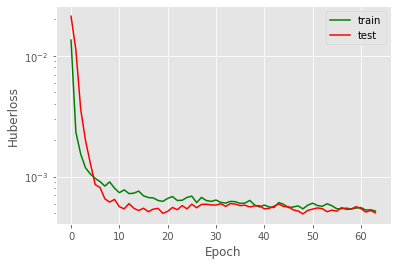

In [15]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.legend()
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')

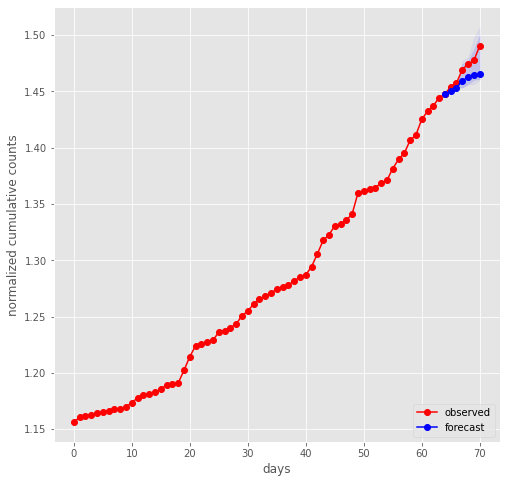

In [16]:
start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon

sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]

def monte_carlo_sample(model, x, n_samples=50, seed=0):
    torch.manual_seed(seed)
    model.train()
    
    # We want the model to be in training mode
    # Except for the BN.
    # There is potentially a more elegant way to do this
    # Ex by making a different "mode" in our own model groups
    model.bn1.training = False
    model.bn2.training = False
    
    samples = []
    for _ in range(n_samples):
        samples.append(model(x).data)
    samples = torch.stack(samples)
    
    model.eval()
    return samples.permute(1, 0, 2)

model.eval()
pred_y = model(sample_x[None, :, :]).squeeze(0).data

samples = monte_carlo_sample(model, sample_x[None, :, :], n_samples=10)
samples = samples.squeeze(0).data.numpy()

sample_mean = samples.mean(0)
sample_std = samples.std(0)

## You can use mean +/- std, or percentile, to visualize the distribtion

# Uncomment to use mean +/- std
#sample_ub = sample_mean + sample_std
#sample_lb = sample_mean - sample_std

# Use percentiles
sample_ub = np.percentile(samples, 90, axis=0)
sample_lb = np.percentile(samples, 10, axis=0)

sample_max = samples.max(0)
sample_min = samples.min(0)

fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
ax.plot(np.arange(end_input, end_output), output_y, 'r', marker='o')
ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='b')
ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='b')
ax.plot(np.arange(end_input, end_output), pred_y, 'b', marker='o', label='forecast')

plt.xlabel('days')
plt.ylabel('normalized cumulative counts')
plt.legend(loc='lower right')
plt.show()

Visualize the forecast

## Trying out new prediction routine 

In [17]:
n_horizons_forcast = 5
start_input = 0
end_input = start_input + input_len
end_output = end_input + n_horizons_forcast*horizon

sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]



In [18]:
predictions = []
outputs_y = []

for i in range(n_horizons_forcast):
    torch.manual_seed(0)
    model.train()
    model.bn1.training = False
    model.bn2.training = False
    _predict = model(sample_x[None,:,:])
    predictions.append(_predict.data.squeeze()) # output?
    sample_x = test_dset.X[start_input+i*horizon:end_input+i*horizon]
    sample_x[None,-horizon:,-1] = _predict.data.squeeze() # replacing last seismic data with the prediction
    model.eval()



# outputs_y.append(output_y)
# _predict = model(sample_x[None,:,:])
# predictions.append(_predict.data.squeeze())

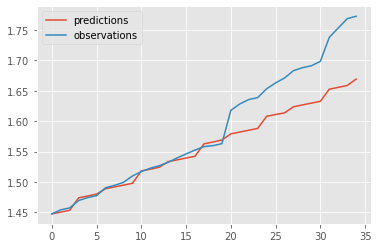

In [19]:
plt.plot(torch.cat(predictions),label='predictions')
plt.plot(output_y,label='observations')
plt.legend()

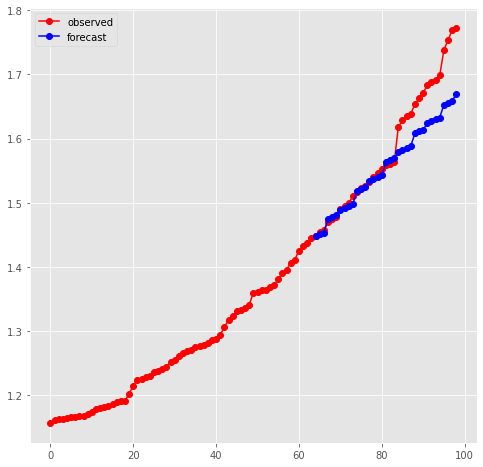

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
ax.plot(np.arange(end_input,end_output),output_y, 'r', marker='o')
ax.plot(np.arange(end_input,end_output), torch.cat(predictions), 'b', marker='o', label='forecast')
ax.legend()

In [21]:
predictions

[tensor([1.4474, 1.4504, 1.4534, 1.4739, 1.4769, 1.4800, 1.4888]),
 tensor([1.4918, 1.4948, 1.4978, 1.5181, 1.5210, 1.5243, 1.5334]),
 tensor([1.5364, 1.5394, 1.5424, 1.5628, 1.5657, 1.5690, 1.5792]),
 tensor([1.5822, 1.5852, 1.5881, 1.6081, 1.6111, 1.6138, 1.6238]),
 tensor([1.6268, 1.6298, 1.6328, 1.6528, 1.6557, 1.6589, 1.6694])]

In [22]:
np.arange(end_input,end_output)

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
       81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
       98])